In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from math import sqrt

In [53]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
validation = pd.read_csv("../data/schemas/warm_up/ValidationSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [54]:
# Global variables

NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

THRESHOLD = 0.5   # For feature selection

In [55]:
columns_to_predict = ["kg_CO2/kWh", "Avg solar generation"]

independent_variables = []

for column in train:
    if abs(train[column].corr(train[columns_to_predict[0]])) > THRESHOLD or abs(train[column].corr(train[columns_to_predict[1]])) > THRESHOLD:
        independent_variables.append(column)

[independent_variables.remove(i) for i in columns_to_predict]
    
if "Index" in independent_variables:
    independent_variables.remove("Index")
if "Solar Generation (W/kW)_1" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_1")
if "Solar Generation (W/kW)_2" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_2")
if "Solar Generation (W/kW)_3" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_3")

Prepare the data

In [56]:
# Split the X and Y for all sets

# Train set
X_train_default = train[independent_variables]
Y_train_default = train[columns_to_predict]

# Validation set, also include the data from train that was used only as output to get more datapoints
X_val_default = pd.concat([X_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[independent_variables]], ignore_index=True)
Y_val_default = pd.concat([Y_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[columns_to_predict]], ignore_index=True)

# Test set, also include the data from train that was used only as output to get more datapoints
X_test_default = pd.concat([X_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[independent_variables]], ignore_index=True)
Y_test_default = pd.concat([Y_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[columns_to_predict]], ignore_index=True)

NUM_OF_ROWS_TRAIN, NUM_OF_FEATURES = X_train_default.shape

print(X_train_default.shape)
print(X_val_default.shape)
print(X_test_default.shape)

(576, 17)
(96, 17)
(96, 17)


In [57]:
# Function to prepare the data into batches that will be passed into the model

def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [58]:
X_train, Y_train = create_sequences(X_train_default, Y_train_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_val, Y_val = create_sequences(X_val_default, Y_val_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_test, Y_test = create_sequences(X_test_default, Y_test_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)

print(f"X_train = {X_train.shape}, Y_train = {Y_train.shape}\n"
      f"X_val = {X_val.shape}, Y_val = {Y_val.shape}\n"
      f"X_test = {X_test.shape}, Y_test = {Y_test.shape}")

X_train = (505, 48, 17), Y_train = (505, 24, 2)
X_val = (25, 48, 17), Y_val = (25, 24, 2)
X_test = (25, 48, 17), Y_test = (25, 24, 2)


In [59]:
print(Y_train[:, :, 0])

[[0.59739428 0.49429981 0.38708765 ... 0.73547528 0.69513525 0.71729728]
 [0.49429981 0.38708765 0.28880037 ... 0.69513525 0.71729728 0.6633147 ]
 [0.38708765 0.28880037 0.2346659  ... 0.71729728 0.6633147  0.55539687]
 ...
 [0.47416969 0.39741721 0.28594384 ... 0.4397153  0.45619247 0.45482902]
 [0.39741721 0.28594384 0.16805223 ... 0.45619247 0.45482902 0.41836388]
 [0.28594384 0.16805223 0.12974031 ... 0.45482902 0.41836388 0.39162712]]


In [60]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 8) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Permute layer
permute_layer = layers.Permute((2, 1))(input_layer)

# Flatten layer
flatten_layer = layers.Flatten()(permute_layer)

# Dense layers for variable 1
dense1 = layers.Dense(1200, activation='tanh')(flatten_layer)
dense2 = layers.Dense(600, activation='tanh')(dense1)
dense3 = layers.Dense(240, activation='tanh')(dense2)
output_variable1 = layers.Dense(24, name='output_variable1')(dense3)

# Dense layers for variable 2
dense4 = layers.Dense(1200, activation='tanh')(flatten_layer)
dense5 = layers.Dense(600, activation='tanh')(dense4)
dense6 = layers.Dense(240, activation='tanh')(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]

    model.compile(
        optimizer='adam',
        loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
    ) #types of optimizer, loss function to be adjusted
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=200, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])

Epoch 1/200
4/4 [==============================] - 3s 168ms/step - loss: 3.6681 - output_variable1_loss: 1.9585 - output_variable2_loss: 1.7096 - val_loss: 0.4938 - val_output_variable1_loss: 0.2771 - val_output_variable2_loss: 0.2167
Epoch 2/200
4/4 [==============================] - 0s 58ms/step - loss: 0.4454 - output_variable1_loss: 0.2427 - output_variable2_loss: 0.2027 - val_loss: 0.1923 - val_output_variable1_loss: 0.1316 - val_output_variable2_loss: 0.0607
Epoch 3/200
4/4 [==============================] - 0s 56ms/step - loss: 0.1454 - output_variable1_loss: 0.0824 - output_variable2_loss: 0.0630 - val_loss: 0.1374 - val_output_variable1_loss: 0.0855 - val_output_variable2_loss: 0.0519
Epoch 4/200
4/4 [==============================] - 0s 72ms/step - loss: 0.1042 - output_variable1_loss: 0.0536 - output_variable2_loss: 0.0505 - val_loss: 0.1186 - val_output_variable1_loss: 0.0870 - val_output_variable2_loss: 0.0315
Epoch 5/200
4/4 [==============================] - 0s 55ms/step

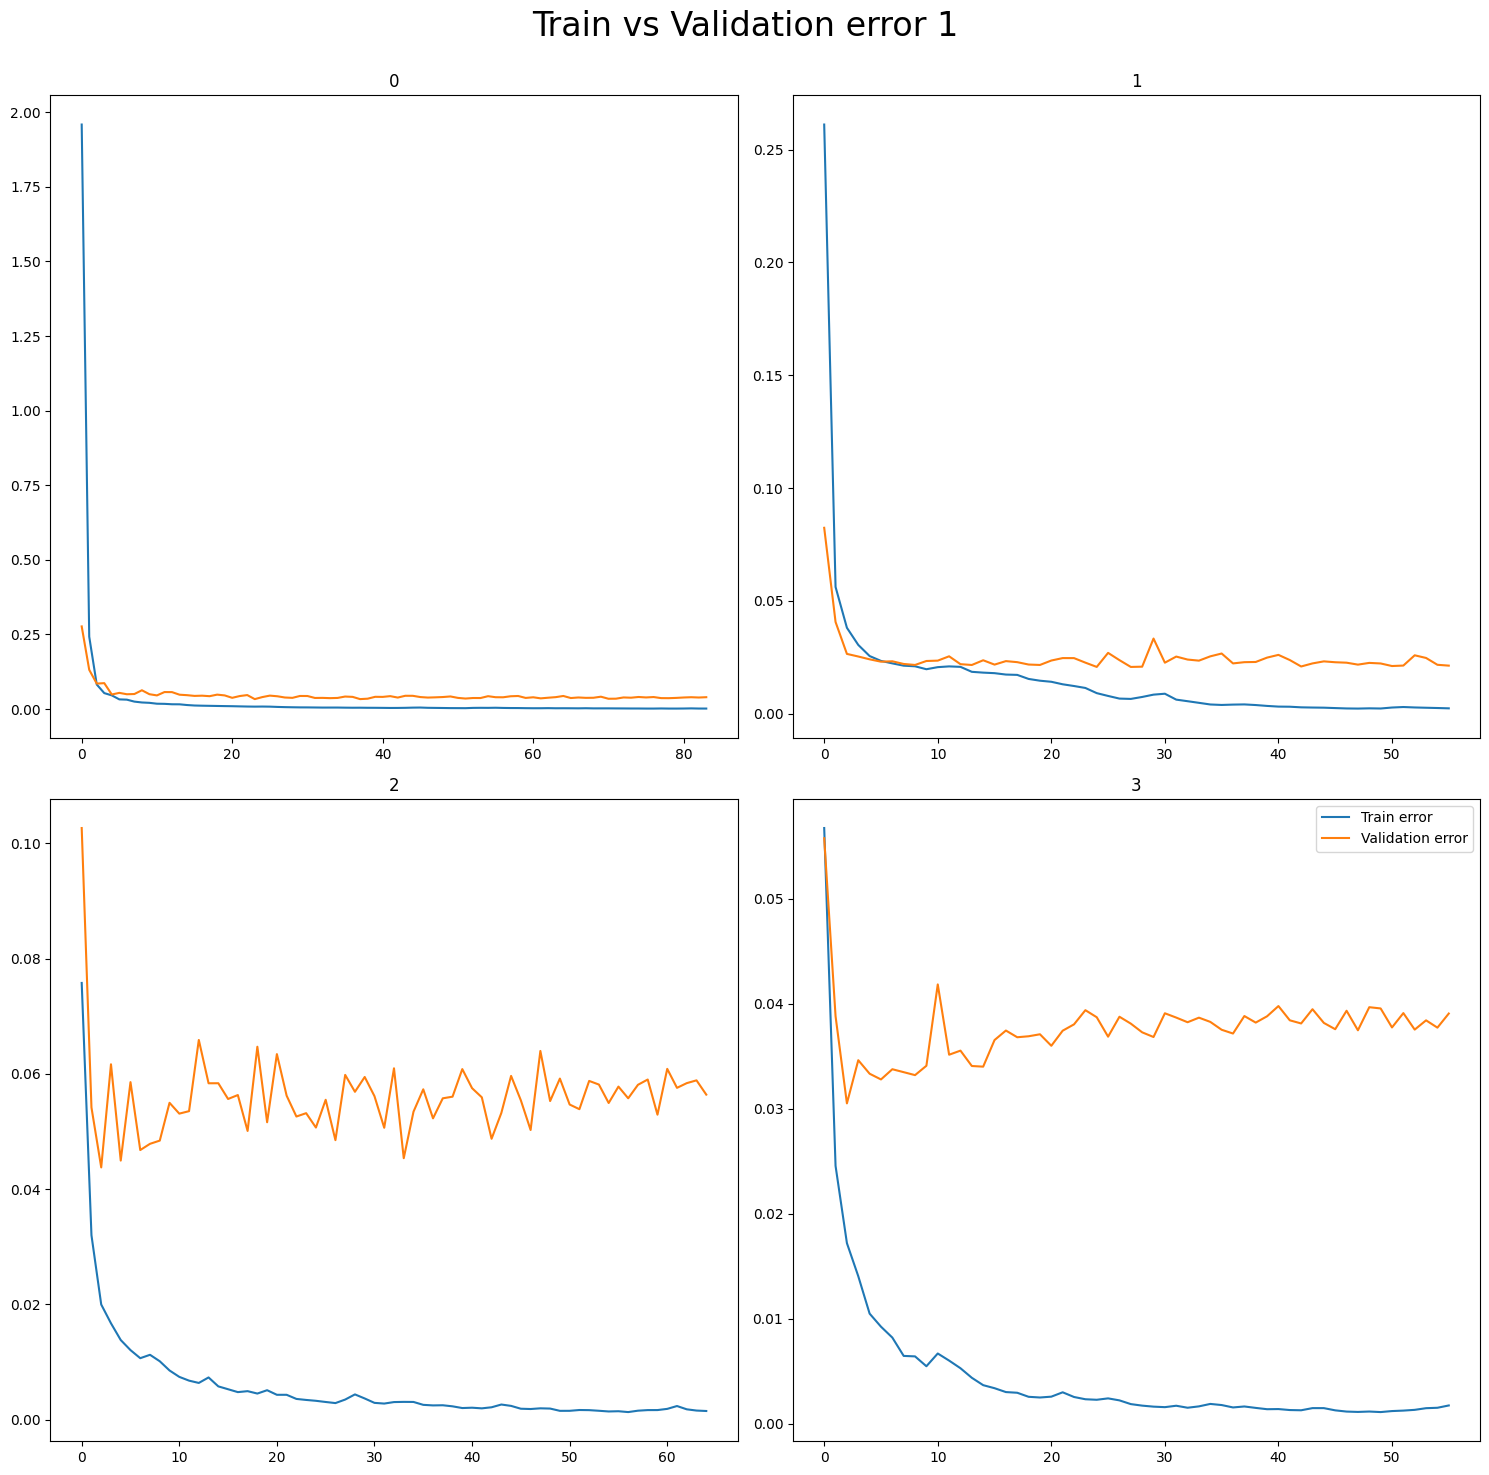

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_1):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_1[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 1", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

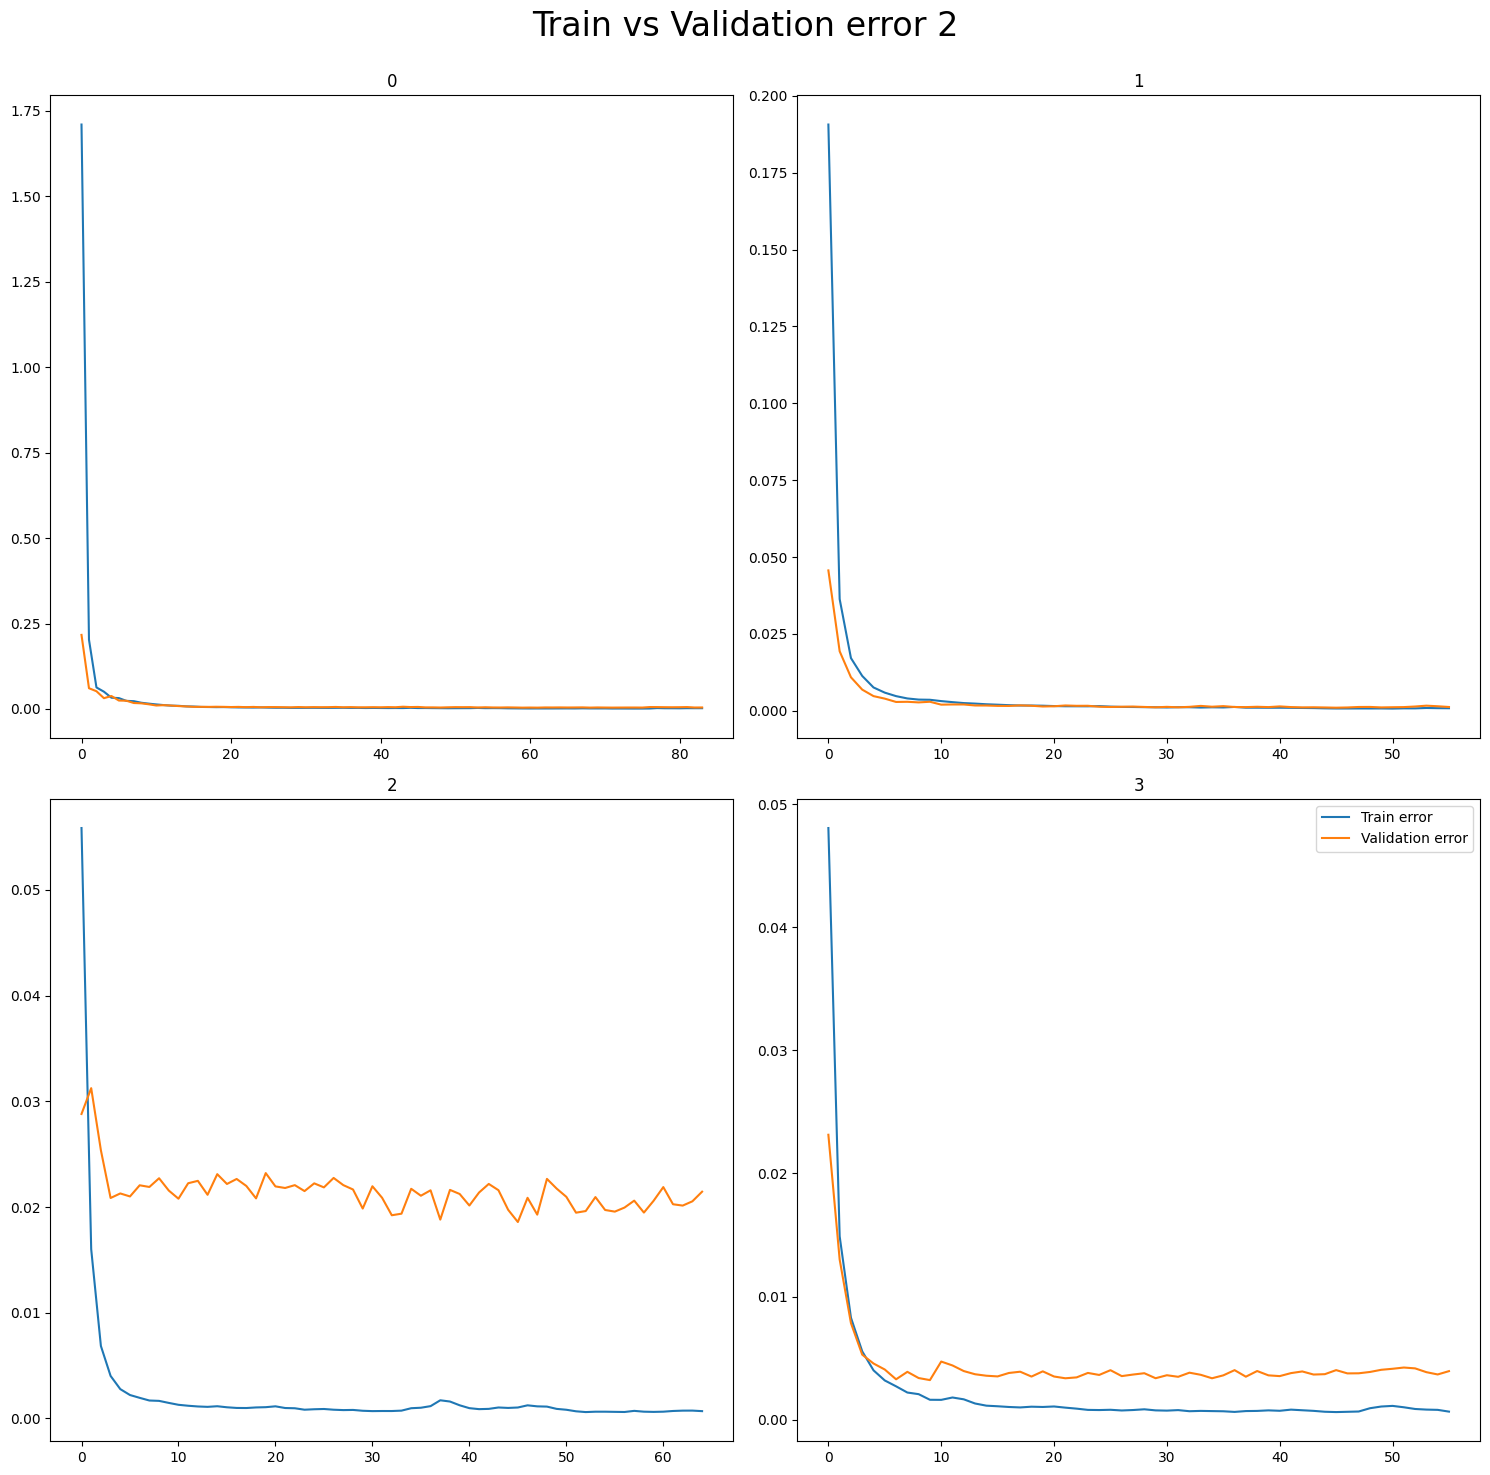

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_2):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_2[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 2", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

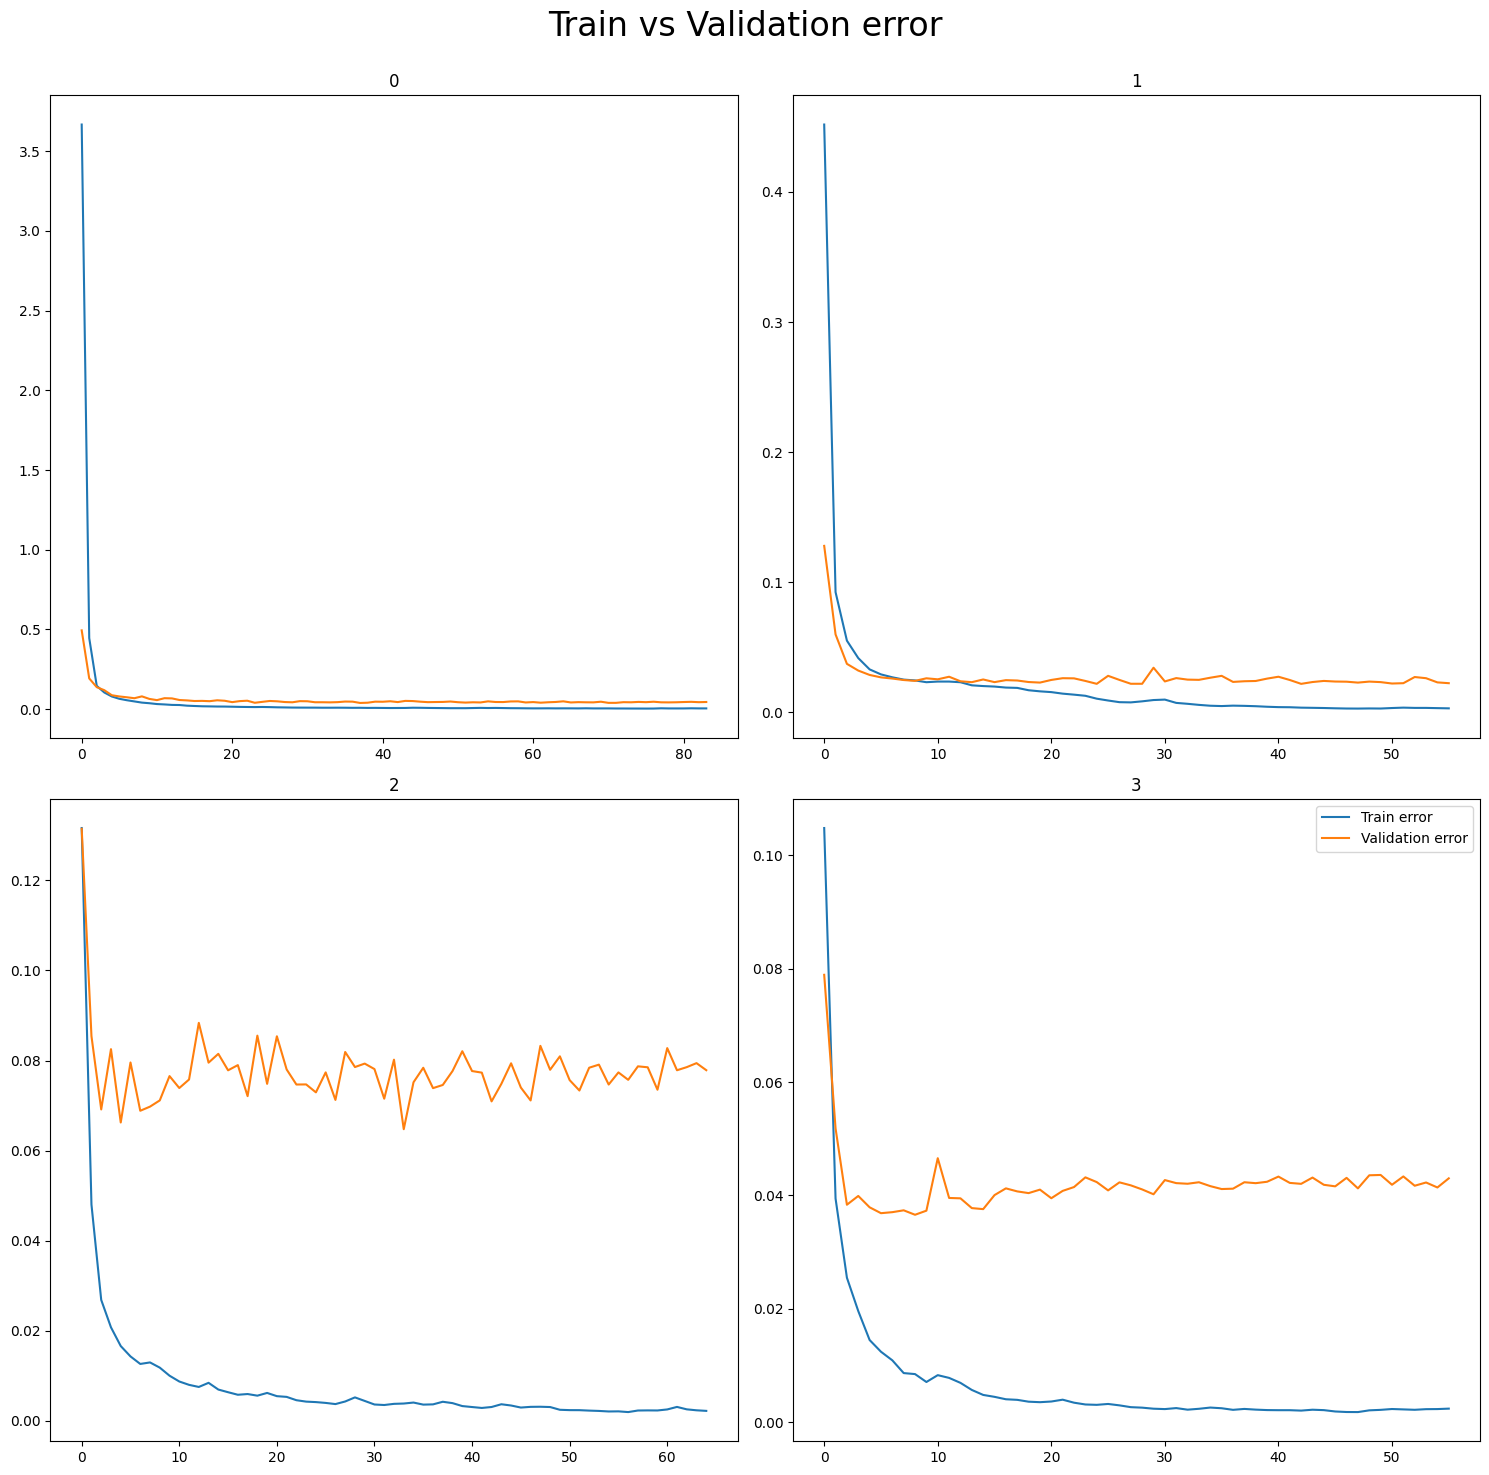

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [65]:
# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)

1/1 [==============================] - 0s 34ms/step


In [66]:
print(predictions_1)

[array([[0.61304253, 0.54233384, 0.45445672, 0.44169626, 0.48974574,
        0.54644215, 0.699978  , 0.74596083, 0.80788743, 0.8304459 ,
        0.8625163 , 0.9186617 , 0.9366614 , 0.9081787 , 0.9153775 ,
        0.8175384 , 0.7291694 , 0.65331817, 0.6742189 , 0.7037106 ,
        0.6656723 , 0.7194431 , 0.6387288 , 0.5790327 ]], dtype=float32), array([[0.52347267, 0.50389314, 0.4585042 , 0.52776724, 0.62217015,
        0.6995244 , 0.8197076 , 0.80356246, 0.8253764 , 0.81804   ,
        0.87427324, 0.92087525, 0.90794134, 0.8246227 , 0.82124203,
        0.74699575, 0.68276805, 0.66166574, 0.6616109 , 0.7051787 ,
        0.6401023 , 0.6419716 , 0.55010086, 0.4480431 ]], dtype=float32), array([[0.47596374, 0.49184388, 0.51847875, 0.6236224 , 0.7200951 ,
        0.78012234, 0.8540521 , 0.85893553, 0.86275655, 0.84195924,
        0.8837788 , 0.88751024, 0.8645241 , 0.7840143 , 0.77825093,
        0.74122626, 0.689556  , 0.69599485, 0.6666913 , 0.66147906,
        0.60197234, 0.5549007 , 0.4

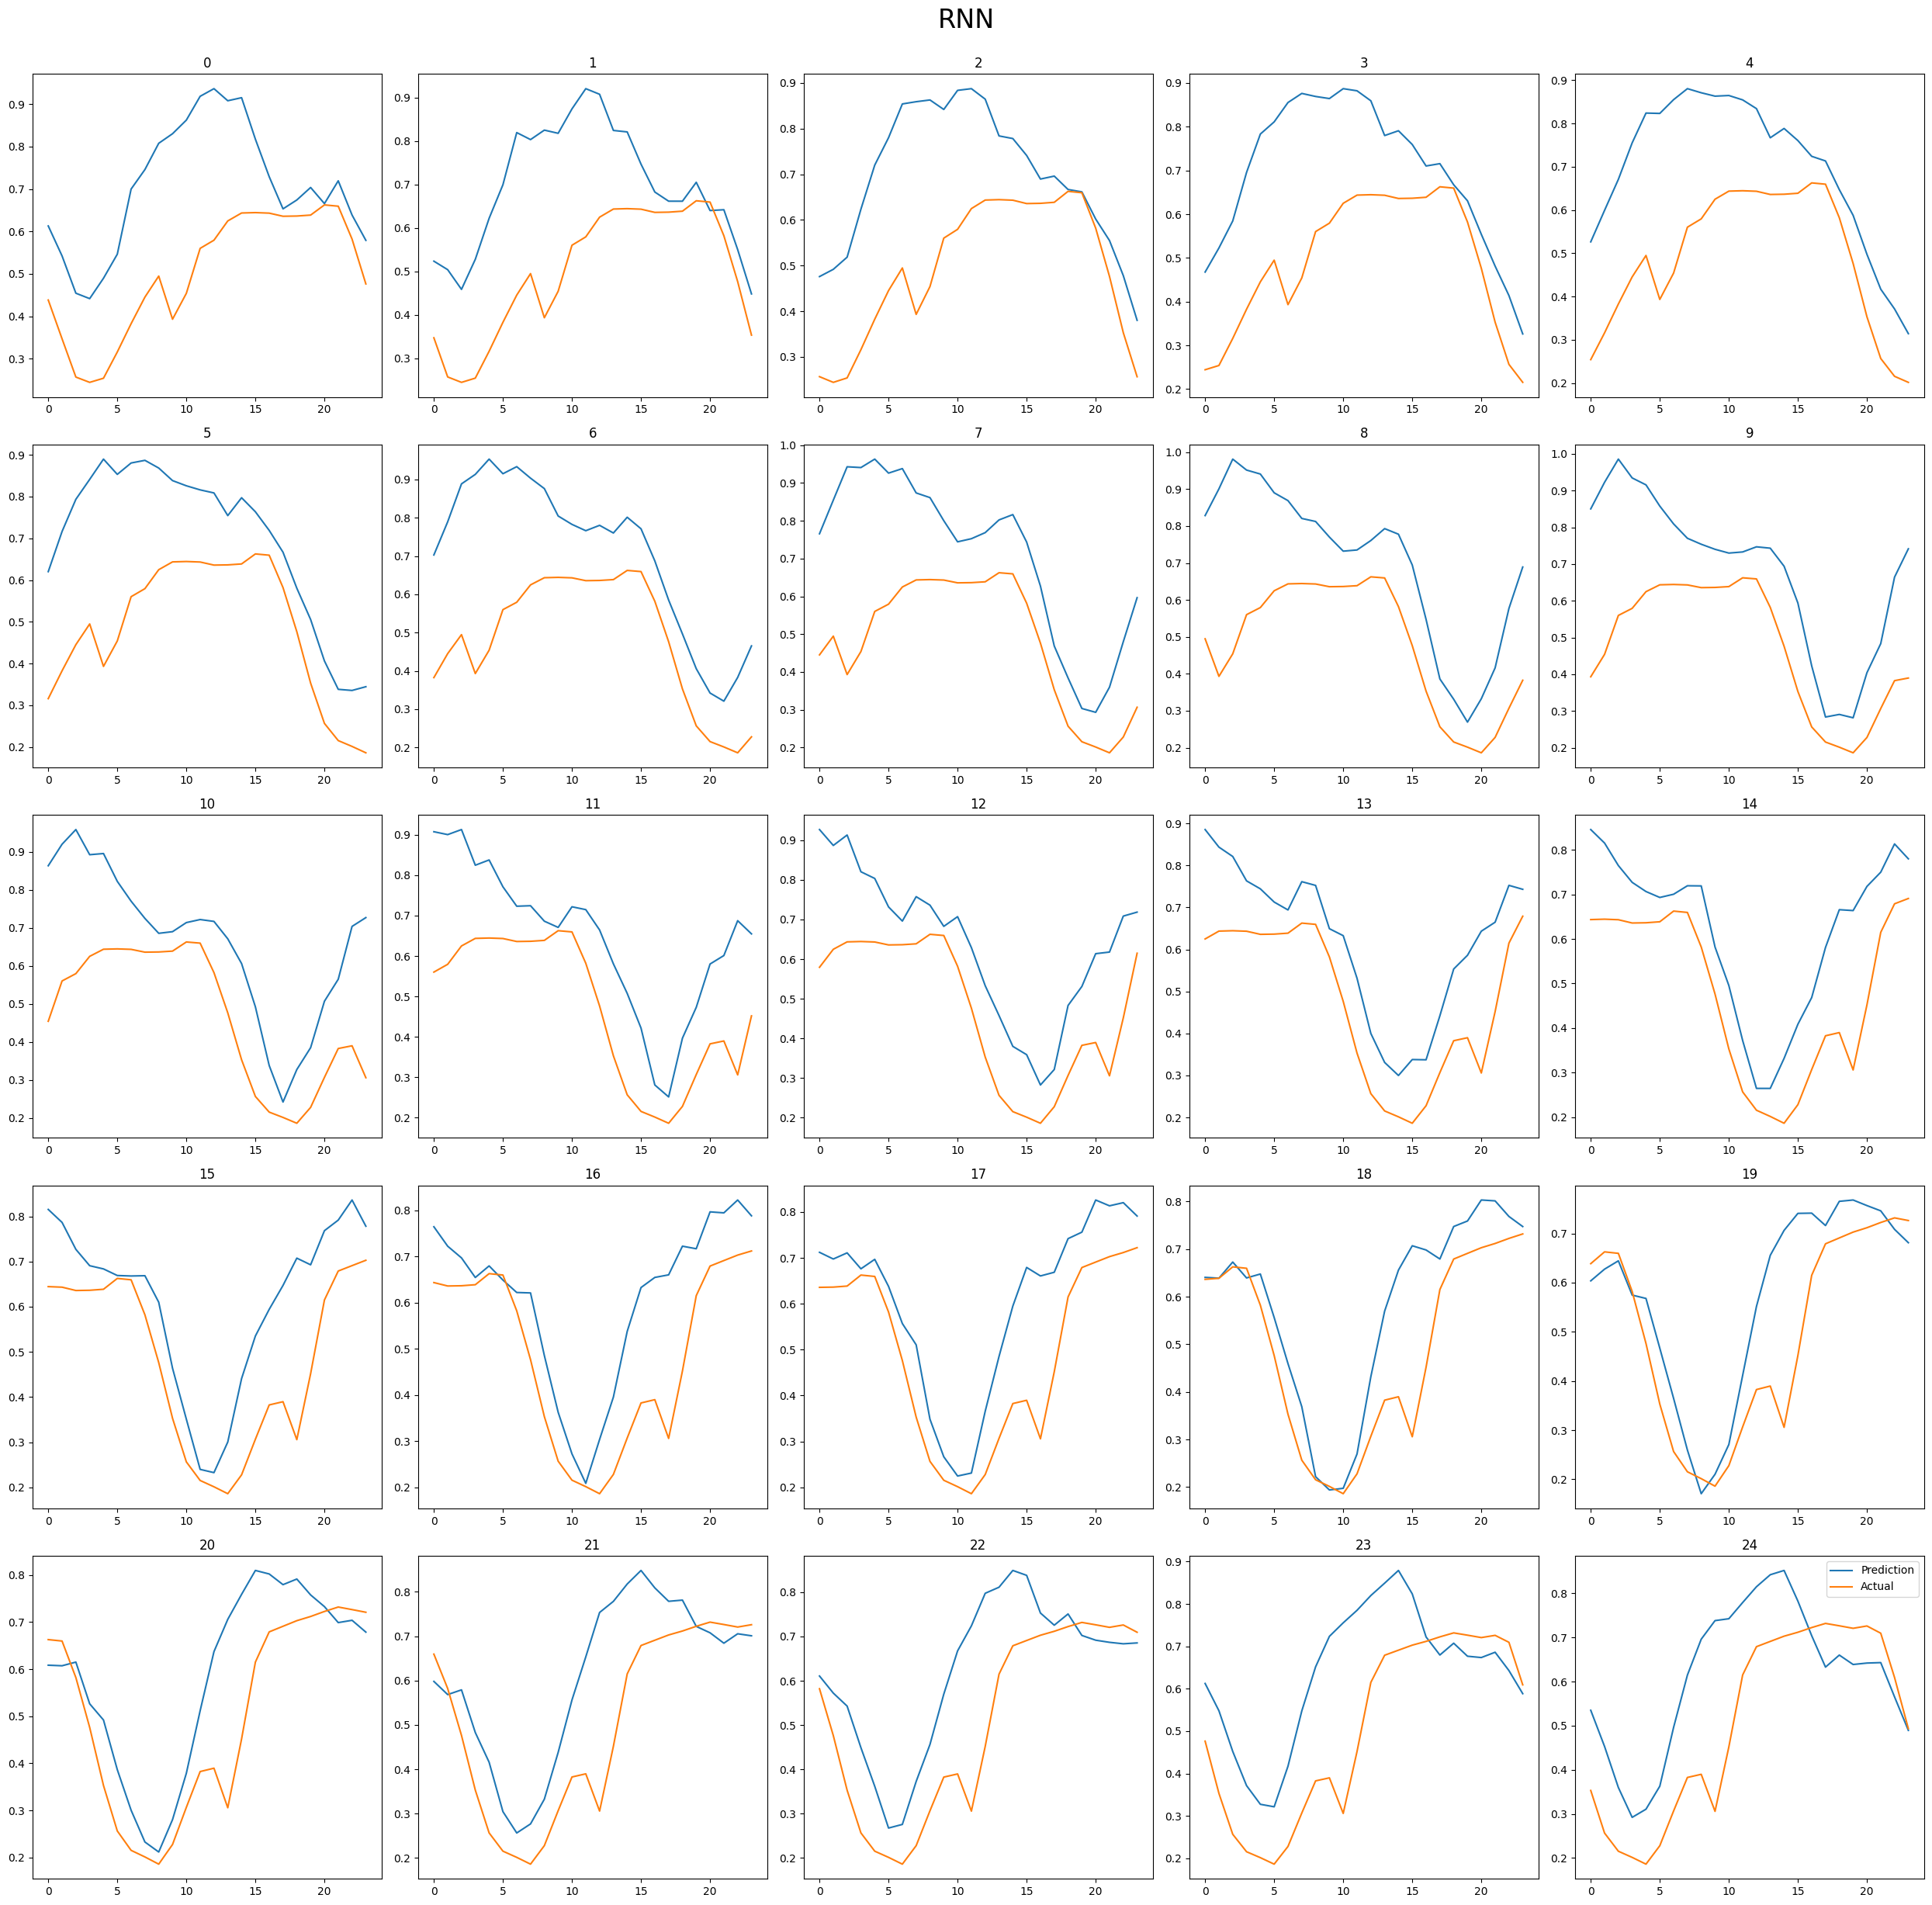

In [67]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_1):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 0], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

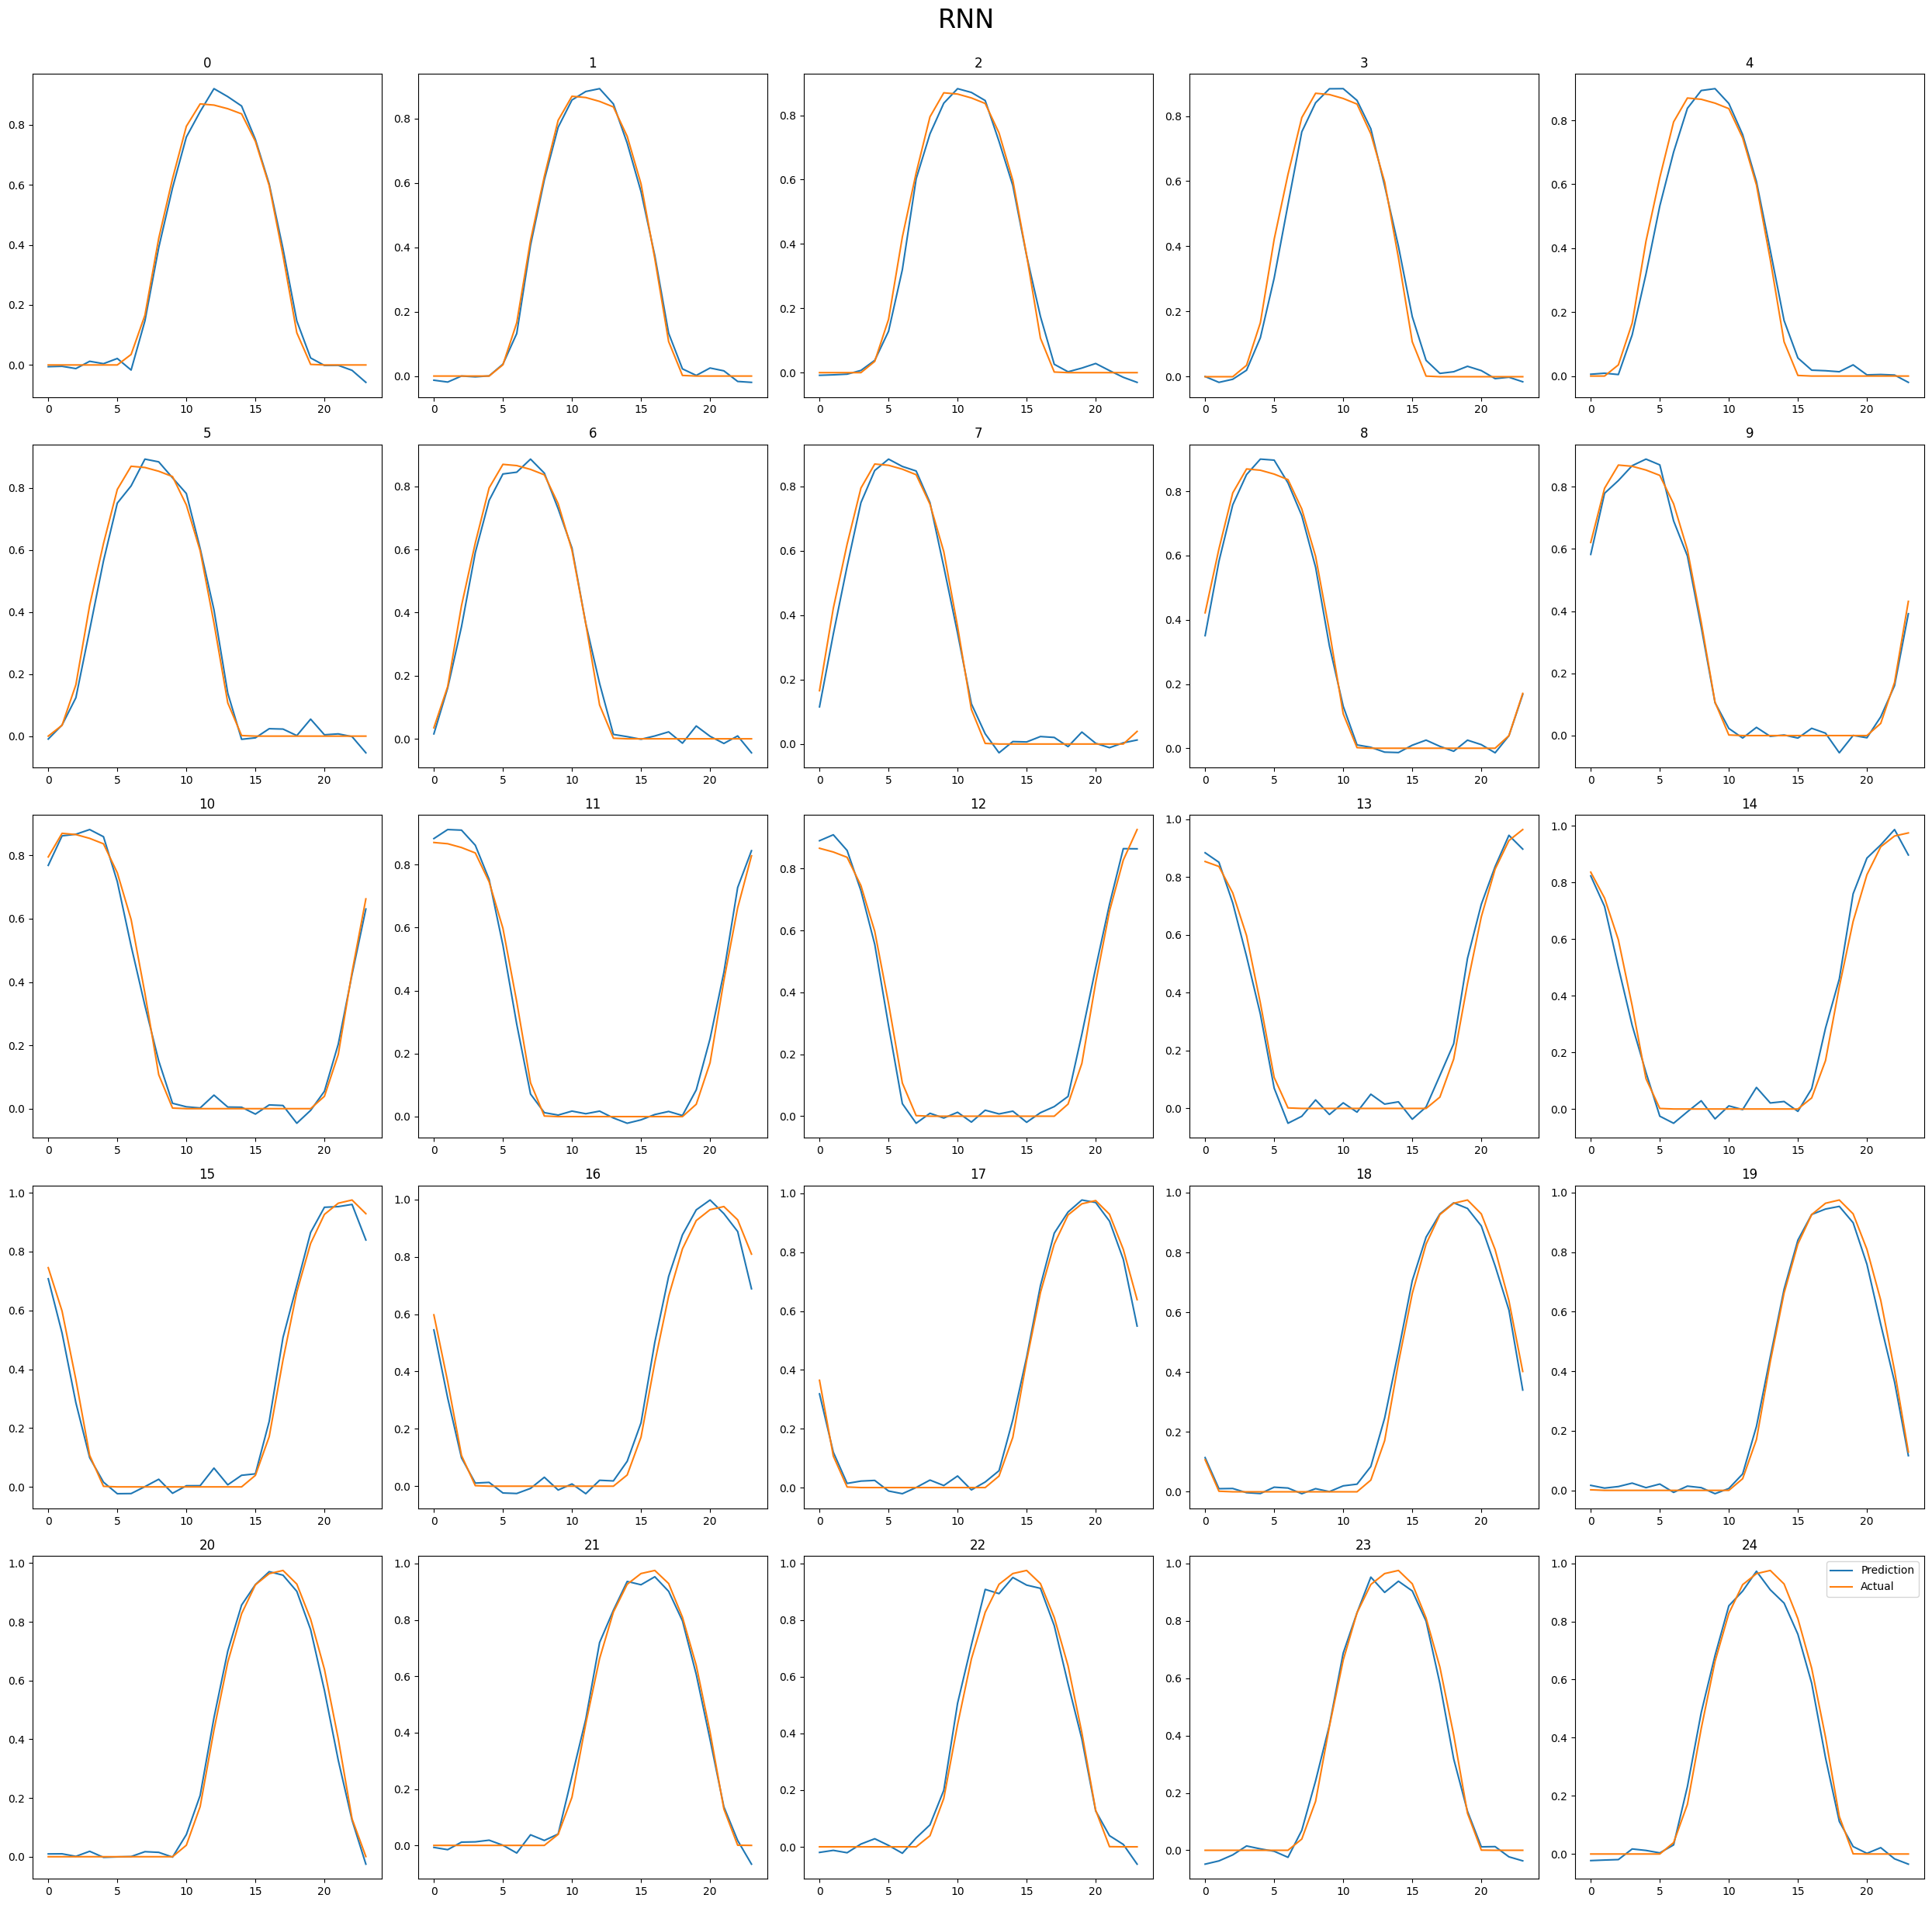

In [68]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_2):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 1], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [69]:
rmse = 0
for i in range(len(predictions_1)):
    print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

pred=0, num = 0.23922078643420386
pred=1, num = 0.2376764105441883
pred=2, num = 0.24110191158811325
pred=3, num = 0.2392350375825249
pred=4, num = 0.23481297989125155
pred=5, num = 0.2426167479265748
pred=6, num = 0.25826696481508493
pred=7, num = 0.2610589436542521
pred=8, num = 0.2548156719114688
pred=9, num = 0.24162906803944492
pred=10, num = 0.22608318601296512
pred=11, num = 0.20020202653560842
pred=12, num = 0.18375977858967
pred=13, num = 0.15808797774874883
pred=14, num = 0.1600569017355773
pred=15, num = 0.1601178709453031
pred=16, num = 0.15297110677658698
pred=17, num = 0.14237082697942144
pred=18, num = 0.13130998693332513
pred=19, num = 0.1334511375026459
pred=20, num = 0.1396931045290341
pred=21, num = 0.15920889568076488
pred=22, num = 0.16644714658644735
pred=23, num = 0.19133133321457282
pred=24, num = 0.17310678806749177
RMSE = 0.19714530360901084


In [70]:
rmse = 0
for i in range(len(predictions_2)):
    print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

pred=0, num = 0.028333767677757284
pred=1, num = 0.018687130924004678
pred=2, num = 0.032257977533986015
pred=3, num = 0.041567791802828005
pred=4, num = 0.043140948202655155
pred=5, num = 0.03555270958381286
pred=6, num = 0.02862781893302091
pred=7, num = 0.03204650401323638
pred=8, num = 0.027304130826702588
pred=9, num = 0.026899943190859005
pred=10, num = 0.029175560357731143
pred=11, num = 0.03524789205141802
pred=12, num = 0.039140946850801966
pred=13, num = 0.04239894615491441
pred=14, num = 0.05118364563135118
pred=15, num = 0.04117705210340938
pred=16, num = 0.04406555843347109
pred=17, num = 0.030785017446614996
pred=18, num = 0.03138946822898121
pred=19, num = 0.02682877326970155
pred=20, num = 0.029792778022099682
pred=21, num = 0.03020811092141437
pred=22, num = 0.03833006466159297
pred=23, num = 0.03597930558130144
pred=24, num = 0.03675112878476571
RMSE = 0.034274918847537285
